## **1)** **Loading Dataset** from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

# Importing the Data file
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv('/content/gdrive/MyDrive/TSA/dataset.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

# Preview Data
print("Size: ", len(data))
data.head()

Size:  1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Mapping Targets to String
decode = {0: 'Negative', 4: 'Positive'}
data.target = data.target.apply(lambda x: decode[int(x)])

# Preview Data
data.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


(800000, 6)
(800000, 6)


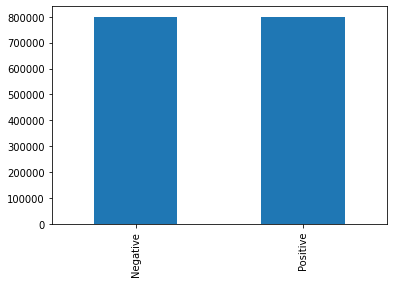

In [ ]:
# Visualize the Samples
print(data[data['target']=='Negative'].shape)
print(data[data['target']=='Positive'].shape)

# Plotting Graph
data.target.value_counts().plot.bar()

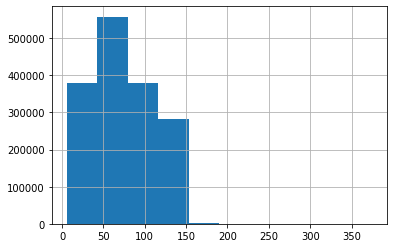

count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
dtype: float64

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Analyzing Tweet Lengths
reviews = [len(x) for x in data['text']]
pd.Series(reviews).hist()
plt.show()

# Summarizing the Analysis
pd.Series(reviews).describe()

## **2) Data Preprocessing**

### Cleaning Text Data

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Removing Stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")

# Stemming text data
stemmer = SnowballStemmer("english")

# Removing Links, Users and Other Characters
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Defining Cleaner Function
def cleaner(text, stem=False):
    text = re.sub(regex, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
# Applying Cleaner
data.text = data.text.apply(lambda x: cleaner(x))

# Preview Data
data.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


### Splitting Dataset

In [ ]:
from sklearn.model_selection import train_test_split

trainData, testData = train_test_split(data, test_size=0.2, random_state=42)
print("Training set size:", len(trainData))
print("Testing set size:", len(testData))

Training set size: 1280000
Testing set size: 320000


### Tokenizing Text

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Setting Up Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(trainData.text)
print("Total Unique Words: ", len(tokenizer.word_index) + 1)

Total Unique Words:  290419


In [ ]:
# Applying Tokenizer
Max_Text_Length = 300

x_train = pad_sequences(tokenizer.texts_to_sequences(trainData.text), maxlen=Max_Text_Length)
x_test = pad_sequences(tokenizer.texts_to_sequences(testData.text), maxlen=Max_Text_Length)

### Encoding Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Setting Up Label Encoder
encoder = LabelEncoder()
encoder.fit(trainData.target.tolist())

LabelEncoder()

In [ ]:
# Applying Label Encoder
y_train = encoder.transform(trainData.target.tolist())
y_test = encoder.transform(testData.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
# Checking Final Datasets
print("X Train Size: ", x_train.shape)
print("Y Train Size: ", y_train.shape)

print("X Test Size: ", x_test.shape)
print("Y Test Size: ", y_test.shape)

X Train Size:  (1280000, 300)
Y Train Size:  (1280000, 1)
X Test Size:  (320000, 300)
Y Test Size:  (320000, 1)


## **3) Sentiment Analysis** using LSTM

### Embedding Layer using Word2Vec

In [ ]:
import gensim

# Setting Up Word2Vec
w2v_Size = 300
w2v_Window = 7
w2v_Epoch = 32
w2v_Min_Count = 10

# Defining Word2Vec Model
w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_Size, window=w2v_Window, min_count=w2v_Min_Count, workers=8)

In [ ]:
# Building Vocabulary
documents = [text.split() for text in trainData.text] 
w2v_model.build_vocab(documents)
print("Vocabulary Size: ", len(w2v_model.wv.vocab.keys()) + 1)

Vocabulary Size:  30370


In [ ]:
# Training Word2Vec Model
w2v_model.train(documents, total_examples=len(documents), epochs=w2v_Epoch)

(229512522, 258305760)

In [ ]:
# Testing Sample
w2v_model.most_similar("kill")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('die', 0.49132657051086426),
 ('cry', 0.3890700936317444),
 ('choke', 0.3856514096260071),
 ('steal', 0.368805468082428),
 ('save', 0.36556869745254517),
 ('scream', 0.3628593385219574),
 ('marry', 0.34182894229888916),
 ('stab', 0.33873501420021057),
 ('ruin', 0.3354349732398987),
 ('help', 0.324670672416687)]

In [ ]:
from keras.layers import Embedding

# Setting Up Embedding Layer
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_Size))

for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

embedding_layer = Embedding(vocab_size, w2v_Size, weights=[embedding_matrix], input_length=Max_Text_Length, trainable=False)

(290419, 300)


### Building and Compiling the Model

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

# Defining Model Architecture
lstmModel = Sequential()

lstmModel.add(embedding_layer)
lstmModel.add(Dropout(0.5))

lstmModel.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstmModel.add(Dense(1, activation='sigmoid'))

print(lstmModel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________
None


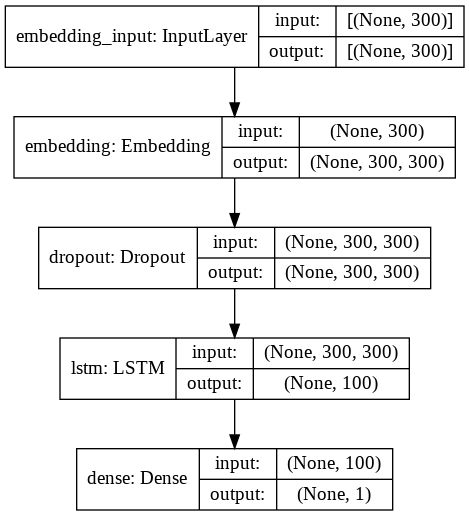

In [ ]:
from keras.utils.vis_utils import plot_model

# Compiling the Model
lstmModel.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# Plotting Model Architecture
plot_model(lstmModel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training and Testing the Model

In [ ]:
Batch_Size = 1024

In [ ]:
modelScore = lstmModel.fit(x_train, y_train, batch_size=Batch_Size, epochs=3, validation_split=0.1, verbose=1)

In [ ]:
# Predicting the Test Data
y_pred = lstmModel.predict(x_test, verbose=1, batch_size=8196)

40/40 [==============================] - 1016s 25s/step


In [ ]:
# Deciding Sentiments on the predicted values
y_pred = np.array([[1 if x > 0.5 else 0 for x in y ] for y in y_pred])

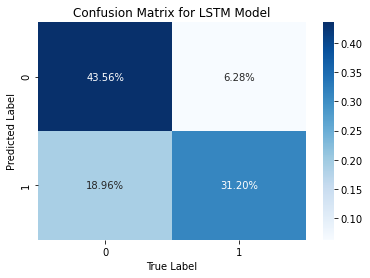

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC ROC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.747553125
F1 Score: 0.7119532467347237
AUC ROC: 0.7479514609179785


## **4) Sentiment Analysis** using other models

### Required Preprocessing 

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling the Data
sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

In [ ]:
# Reshaping the Data
Y_train=y_train.reshape(-1)
Y_test=y_test.reshape(-1)

### Linear Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# Defining Model
model = LogisticRegression()

# Training Model
model.fit(X_train, Y_train)

# Predicting Results
y_pred = model.predict(X_test)

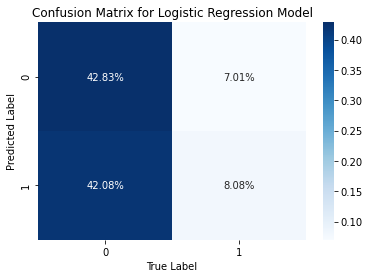

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC ROC:", roc_auc_score(Y_test, y_pred))

Accuracy: 0.50915625
F1 Score: 0.24771301307533886
AUC ROC: 0.5102604208998877


### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Defining Model
model = DecisionTreeClassifier()

# Training Model
model.fit(X_train, Y_train)

# Predicting Results
y_pred = model.predict(X_test)

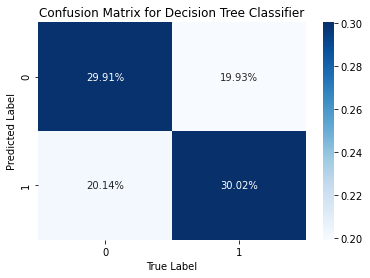

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC ROC:", roc_auc_score(Y_test, y_pred))

Accuracy: 0.599315625
F1 Score: 0.5997296546384834
AUC ROC: 0.599318347815332


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Defining Model
model = RandomForestClassifier(max_depth=3)

# Training Model
model.fit(X_train, Y_train)

# Predicting Results
y_pred = model.predict(X_test)

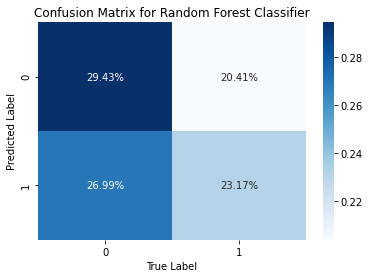

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print("AUC ROC:", roc_auc_score(Y_test, y_pred))

Accuracy: 0.526034375
F1 Score: 0.4943911618712351
AUC ROC: 0.5262375612015711


### Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

# Defining Model
model = SVC()

# Training Model
model.fit(X_train, Y_train)

# Predicting Results
y_pred = model.predict(X_test)

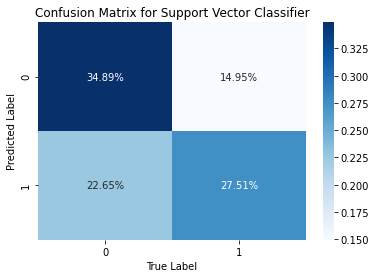

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix for Support Vector Classifier')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Performance Measures
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC ROC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.624059375
F1 Score: 0.5940864659497724
AUC ROC: 0.6242991398458817


## **Others**

### Tokenizer: Saving and Loading

In [ ]:
import pickle

# Setting Up Path
tokenizer_Path = '/content/gdrive/MyDrive/TSA/tokenizer.pkl'

In [ ]:
# Loading Tokenizer
tokenizer = pickle.load(open(tokenizer_Path, "rb"))

In [ ]:
# Saving Tokenizer
pickle.dump(tokenizer, open(tokenizer_Path, "wb"), protocol=0)

### Encoder: Saving and Loading

In [ ]:
import pickle

# Setting Up Path
encoder_Path = '/content/gdrive/MyDrive/TSA/encoder.pkl'

In [ ]:
# Loading Encoder
encoder = pickle.load(open(encoder_Path, "rb"))

In [ ]:
# Saving Encoder
pickle.dump(encoder, open(encoder_Path, "wb"), protocol=0)

### Word2Vec: Saving and Loading

In [ ]:
# Setting Up Path
w2v_Path = '/content/gdrive/MyDrive/TSA/w2vModel.w2v'

In [ ]:
# Loading the Model
w2v_model = gensim.models.Word2Vec.load(w2v_Path)

In [ ]:
# Saving the Model
w2v_model.save(w2v_Path)

### LSTM Model: Saving and Loading

In [ ]:
# Setting Up Path
lstm_Path = '/content/gdrive/MyDrive/TSA/lstmModel.h5'

In [ ]:
from tensorflow.keras.models import load_model

# Loading the Model
lstmModel = load_model(lstm_Path)

In [ ]:
# Saving the Model
lstmModel.save_weights(lstm_Path)